**Author:** Srikaran Elakurthy

**Description:**

The current algorithm trains a Neural network to predict a shot would become a scene boundary. This prediction is done by analysing the different movie shots. 

Horizontally stacked the Place,cast,audio and action features for each shot.

1.   Considering an even sliding window where we consider before and after shots for Each shot. For Example if we are considering the window as 4 then for shot no:6 then we will consider shot number 5,6,7,8 where 5,6 becomes the left window and 7,8 becomes the right window. 
2. In this architecture we capture the differences and relations information between the shots and predict shot boundary at segment level.
3. At Shot boundary representation at clip level we first divide of Convolution model into branches B1 and B2. B1 is modeled by two temoral convolution layers, each of them embeds the shots before and after the boundary respectively, following an inner product operation to calculate their differences. B2 aims to capture the relations of the shots, it is implemented by a temporal convolution layer followed a max pooling. Then both the branches are concatenated and sent for prediction at segment level.
4. From the above convolutions we sent to BiLSTM's to capture the segment level information and predict the scene boundary
5.   The model architecture is at the bottom of this ipynb file.
6.  Here we considered Focal Loss as our Loss function due to Class Imbalance dataset.


**Metrics:**
The best Miou we got 0.37

"AP": 0.2227305314208436,

"mAP": 0.2456567560848962,

"Miou": 0.37807352695300483,

"Precision": 0.17614795888463655,

"Recall": 0.616970439751943,

"F1": 0.26742347137195127





In [ ]:
pip install focal-loss

In [2]:
import os
import sys
import glob
import json
import pickle
import torch
import tensorflow as tf
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers.core import SpatialDropout1D
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Activation, Flatten
from keras.layers import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical 
import random
import torch
from focal_loss import BinaryFocalLoss
from keras.models import Model


In [3]:
#Load Train and test datasets and intializing window as 8
sourcefolder='/content/drive/MyDrive/eluvio/eluvio'
fd=open('{}/split_data/train_raw_data.pkl'.format(sourcefolder),'rb')
train_raw_data=pickle.load(fd)
fd.close()
fd=open('{}/split_data/test_raw_data.pkl'.format(sourcefolder),'rb')
test_raw_data=pickle.load(fd)
fd.close()
window=8

In [31]:
#calculation for metrics
def calc_ap(gt_dict, pr_dict):
    """Average Precision (AP) for scene transitions.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
    Returns:
        AP, mean AP, and a dict of AP for each movie.
    """
    
    assert gt_dict.keys() == pr_dict.keys()
    
    AP_dict = dict()
    gt = list()
    pr = list()
    for imdb_id in gt_dict.keys():
        AP_dict[imdb_id] = average_precision_score(gt_dict[imdb_id], pr_dict[imdb_id])
        gt.append(gt_dict[imdb_id])
        pr.append(pr_dict[imdb_id])

    mAP = sum(AP_dict.values()) / len(AP_dict)

    gt = np.concatenate(gt)
    pr = np.concatenate(pr)
    AP = average_precision_score(gt, pr)

    return AP, mAP, AP_dict


def calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict, threshold=0.5):
    """Maximum IoU (Miou) for scene segmentation.
    Miou measures how well the predicted scenes and ground-truth scenes overlap. The descriptions can be found in
    https://arxiv.org/pdf/1510.08893.pdf. Note the length of intersection or union is measured by the number of frames.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        shot_to_end_frame_dict: End frame index for each shot.
        threshold: A threshold to filter the predictions.
    Returns:
        Mean MIoU, and a dict of MIoU for each movie.
    """
    def iou(x, y):
        s0, e0 = x
        s1, e1 = y
        smin, smax = (s0, s1) if s1 > s0 else (s1, s0)
        emin, emax = (e0, e1) if e1 > e0 else (e1, e0)
        return (emin - smax + 1) / (emax - smin + 1)

    def scene_frame_ranges(scene_transitions, shot_to_end_frame):
        end_shots = np.where(scene_transitions)[0]
        scenes = np.zeros((len(end_shots) + 1, 2), dtype=end_shots.dtype)
        scenes[:-1, 1] = shot_to_end_frame[end_shots]
        scenes[-1, 1] = shot_to_end_frame[len(scene_transitions)]
        scenes[1:, 0] = scenes[:-1, 1] + 1
        return scenes

    def miou(gt_array, pr_array, shot_to_end_frame):
        gt_scenes = scene_frame_ranges(gt_array, shot_to_end_frame)
        pr_scenes = scene_frame_ranges(pr_array >= threshold, shot_to_end_frame)
        assert gt_scenes[-1, -1] == pr_scenes[-1, -1]

        m = gt_scenes.shape[0]
        n = pr_scenes.shape[0]

        # IoU for (gt_scene, pr_scene) pairs
        iou_table = np.zeros((m, n))

        j = 0
        for i in range(m):
            # j start prior to i end
            while pr_scenes[j, 0] <= gt_scenes[i, 1]:
                iou_table[i, j] = iou(gt_scenes[i], pr_scenes[j])
                if j < n - 1:
                    j += 1
                else:
                    break
            # j end prior to (i + 1) start
            if pr_scenes[j, 1] < gt_scenes[i, 1] + 1:
                break
            # j start later than (i + 1) start
            if pr_scenes[j, 0] > gt_scenes[i, 1] + 1:
                j -= 1
        assert np.isnan(iou_table).sum() == 0
        assert iou_table.min() >= 0

        # Miou
        return (iou_table.max(axis=0).mean() + iou_table.max(axis=1).mean()) / 2

    assert gt_dict.keys() == pr_dict.keys()

    miou_dict = dict()

    for imdb_id in gt_dict.keys():
        miou_dict[imdb_id] = miou(gt_dict[imdb_id], pr_dict[imdb_id], shot_to_end_frame_dict[imdb_id])
    mean_miou = sum(miou_dict.values()) / len(miou_dict)

    return mean_miou, miou_dict


def calc_precision_recall(gt_dict, pr_dict, threshold=0.5):
    """Precision, Recall and F1 for scene transitions at a given threshold.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        threshold: A threshold to filter the predictions.
    Returns:
        Mean Precision, Recall, and F1, per IMDB ID Precisions, Recalls, and F1 scores.
    """
    def precision_recall(gt_array, pr_array):
        tp_fn = gt_array == 1
        tp_fp = pr_array >= threshold

        tps = (tp_fn & tp_fp).sum()

        precision = tps / tp_fp.sum()
        recall = tps / tp_fn.sum()

        return np.nan_to_num(precision), np.nan_to_num(recall)

    assert gt_dict.keys() == pr_dict.keys()

    precision_dict = dict()
    recall_dict = dict()
    fscore_dict = dict()

    for imdb_id in gt_dict.keys():
        p, r = precision_recall(gt_dict[imdb_id], pr_dict[imdb_id])
        precision_dict[imdb_id] = p
        recall_dict[imdb_id] = r
        fscore_dict[imdb_id] = 2 * p * r / (p + r)

    n = len(gt_dict)
    mean_precision = sum(precision_dict.values()) / n
    mean_recall = sum(recall_dict.values()) / n
    mean_fscore = sum(fscore_dict.values()) / n

    return mean_precision, mean_recall, mean_fscore, precision_dict, recall_dict, fscore_dict



In [ ]:
#Extracts shot level data from each movie and performs window operation 
#Padding is also performed at movie level if we consider first shot and our window is 8 
#then for first shot padding length of 3 shots is done before the shot
def preprocess_and_transform(window,movie_raw_data,train_data=True):
  """Extracts the shot information and stack the before and after shots to capture the clip level information.
    Args:
        window: Size of the sliding window .
        movie_raw_data: Movie data.
        train_data: (Boolean)If the movie raw data is a trian data or test data.
    Returns:
        Transformed shot level tensors and ground truths for each shots
    """
  left_padding_len=int((window-1)/2)
  right_padding_len=left_padding_len+1
  shot_level=[]
  
  movies=list(movie_raw_data.keys())
  ground_truth_lst=[]
  movie_level=dict()
  for movie_file in movies:
    shot_place_tensor=movie_raw_data[movie_file]['place'][:-1]
    shot_action_tensor=movie_raw_data[movie_file]['action'][:-1]
    shot_audio_tensor=movie_raw_data[movie_file]['audio'][:-1]
    shot_cast_tensor=movie_raw_data[movie_file]['cast'][:-1]
    shot_tensor=torch.hstack((shot_place_tensor,shot_action_tensor,shot_audio_tensor,shot_cast_tensor))
    ground_truth_lst.append(movie_raw_data[movie_file]['scene_transition_boundary_ground_truth'])
    shot_test=[]
    for t in range(0,shot_tensor.shape[0]):
    #print(t)
      if (t==0) or ((t+right_padding_len)>(shot_tensor.shape[0]-1)) or ((t-left_padding_len)<0):
        #print(shot_tensor.shape[1])
        #print(padding_len)
        #zerotensor = torch.zeros((padding_len,shot_tensor.shape[1]))
        if t==0:
          zerotensor = torch.zeros((left_padding_len,shot_tensor.shape[1]))
          #print(t)
          temp=torch.vstack((zerotensor,shot_tensor[t]))
          shot=torch.vstack((temp,shot_tensor[t+1:t+right_padding_len+1]))
        elif t== (shot_tensor.shape[0]-1):
          #print(t)
          zerotensor = torch.zeros((right_padding_len,shot_tensor.shape[1]))
          #temp=torch.vstack((shot_tensor[t-padding_len:t],shot_tensor[t]))
          shot=torch.vstack((shot_tensor[t-left_padding_len:],zerotensor))
          #print('shot1:',shot.shape)
        elif (t+right_padding_len)>(shot_tensor.shape[0]-1):
          #print(t)
          pad_len=(right_padding_len-((shot_tensor.shape[0]-1)-(t)))
          zerotensor = torch.zeros(pad_len,shot_tensor.shape[1])
          
          #print(zerotensor.shape)
          #temp=torch.vstack((shot_tensor[t-padding_len:t],shot_tensor[t]))
          #print("temp:",temp.shape)
          #print('zero:',zerotensor.shape)
          #print(shot_tensor[(t-left_padding_len):(shot_tensor.shape[0])].shape)
          shot=torch.vstack((shot_tensor[(t-left_padding_len):(shot_tensor.shape[0])],zerotensor))
          #print('shot2:',shot.shape)
        elif (t-left_padding_len)<0:
          zerotensor = torch.zeros((left_padding_len-t,shot_tensor.shape[1]))
          #print(t)
          
          temp=torch.vstack((zerotensor,shot_tensor[0:t+1]))
          shot=torch.vstack((temp,shot_tensor[t+1:t+right_padding_len+1]))

          #print('shot3:',shot.shape)
      else:
        shot=shot_tensor[t-left_padding_len:t+right_padding_len+1]
      if train_data==False:
        shot_test.append(shot)
      shot_level.append(shot)
    if train_data==False:
      test_shot_level=torch.stack(shot_test)
      movie_level[movie_file]={}
      movie_level[movie_file]['shot_tensor']=test_shot_level
      movie_level[movie_file]['ground_truth']=movie_raw_data[movie_file]['scene_transition_boundary_ground_truth']
      movie_level[movie_file]['shot_end_frame']=movie_raw_data[movie_file]['shot_end_frame']
  if train_data == True:
    shot_level=torch.stack(shot_level)
    ground_truth_tensor=torch.cat(ground_truth_lst)
    return shot_level,ground_truth_tensor
  else:
    return movie_level


In [ ]:
def predict(test_movies,trained_model):
  """Takes the transformed testdata where shots are stacked with window operation and transforms to pytorch tensors 
  to the Tensorflow tensors and predict scene boundary for each shot
    Args:
        test_movies: transformed testdata where shots are stacked with window.
        trained_model: Model used for predicting the shot
        
    Returns:
        ground truths, predictions of each shot for movies and shot end frames for each movie. 
    """
  gt_dict = dict()
  pr_dict = dict()
  shot_to_end_frame_dict = dict()

  for test_mov in test_movies:
    test_X=test_movies[test_mov]['shot_tensor']
    test_Y=test_movies[test_mov]['ground_truth']
    test_X_np=test_X.numpy()
    test_X=tf.convert_to_tensor(test_X_np)
    #print(test_X.shape)
    y_pred=trained_model.predict(test_X)
    #print(y_pred.shape)
    
    gt_dict[test_mov] = test_Y
    pr_dict[test_mov] = torch.from_numpy(y_pred).flatten()
   

    shot_to_end_frame_dict[test_mov] = test_movies[test_mov]["shot_end_frame"]
  
  return gt_dict,pr_dict,shot_to_end_frame_dict

In [5]:
#Preparing and transforming the train data to shot level with window as 8

train_X,train_Y=preprocess_and_transform(window,train_raw_data,train_data=True)


In [6]:
#Converts Train Pytorch tensor to TensorFlow Tensor and labeling the ground truths

train_X_np=train_X.numpy()
train_Y_np=train_Y.numpy()
encoder = LabelEncoder()
encoder.fit(train_Y_np)
train_Y = encoder.transform(train_Y_np)
train_X=tf.convert_to_tensor(train_X_np)
train_Y=tf.convert_to_tensor(train_Y)


In [ ]:
#building the Neural Network Model using CNNs and LSTM's using Functional Tensorflow instead of Seuqntial. 
#Detailed description of architecture is provided at the end of the program. 
# Due toClass imbalance we are using Focal loss .
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
inputs = tf.keras.layers.Input(shape=train_X.shape[1:])
s0,s1=tf.split(inputs,num_or_size_splits=2,axis=1)
#cnn_layer=Conv1D(filters=100, kernel_size=2,padding='valid',strides=1, activation='relu')
left_shot=Conv1D(filters=100, kernel_size=2,padding='valid',strides=1, activation='relu')(s0)
right_shot=Conv1D(filters=100, kernel_size=2,padding='valid',strides=1, activation='relu')(s1)
full_shot=cnn_layer(inputs)
full_shot=MaxPooling1D(pool_size=2,strides=2)(full_shot)
dotted = tf.keras.layers.Dot(axes=2)([left_shot, right_shot])
combined=tf.keras.layers.Concatenate()([full_shot,dotted])
lstm_out=tf.keras.layers.LSTM(activation='relu',units=100,return_sequences=True)(combined)
lstm_out=Flatten()(lstm_out)
lstm_out=Dense(100,activation='relu')(lstm_out)
out=Dense(1,activation='sigmoid')(lstm_out)
model=Model(inputs,out)
model.compile(loss=BinaryFocalLoss(pos_weight = 9, gamma = 2.5), optimizer='adam', metrics=['accuracy'])


In [ ]:
#Due to early Stopping and patience value set to 10 the epochs ended at 17

epochs = 100
batch_size = 128

history = model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/100
536/536 [==============================] - 22s 38ms/step - loss: 0.1713 - accuracy: 0.7493 - val_loss: 0.1745 - val_accuracy: 0.8453
Epoch 2/100
536/536 [==============================] - 20s 38ms/step - loss: 0.1439 - accuracy: 0.8073 - val_loss: 0.1734 - val_accuracy: 0.8147
Epoch 3/100
536/536 [==============================] - 19s 36ms/step - loss: 0.1362 - accuracy: 0.8158 - val_loss: 0.1707 - val_accuracy: 0.7985
Epoch 4/100
536/536 [==============================] - 19s 36ms/step - loss: 0.1327 - accuracy: 0.8203 - val_loss: 0.1761 - val_accuracy: 0.6846
Epoch 5/100
536/536 [==============================] - 19s 36ms/step - loss: 0.1339 - accuracy: 0.8054 - val_loss: 0.1784 - val_accuracy: 0.6887
Epoch 6/100
536/536 [==============================] - 19s 36ms/step - loss: 0.1291 - accuracy: 0.8089 - val_loss: 0.1732 - val_accuracy: 0.7556
Epoch 7/100
536/536 [==============================] - 19s 36ms/step - loss: 0.1305 - accuracy: 0.8063 - val_loss: 0.1697 - val_ac

In [ ]:
#saving the model
model.save("{}/shot_split/shot_split_win_8.1.h5".format(sourcefolder))

In [6]:
#Loading the model
model_8_1=tf.keras.models.load_model("{}/shot_split/shot_split_win_8.1.h5".format(sourcefolder))

In [ ]:
#Transforming the test raw data

test_transform=preprocess_and_transform(8,test_raw_data,train_data=False)

In [30]:
#Predicting the shot is a scene boundary or not
gt_dict,pr_dict,shot_to_end_frame_dict=predict(test_transform,model_8_1)

In [33]:
#Metrics
scores = dict()
scores["AP"], scores["mAP"], _ = calc_ap(gt_dict, pr_dict)
scores["Miou"], _ = calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict)
scores["Precision"], scores["Recall"], scores["F1"], *_ = calc_precision_recall(gt_dict, pr_dict)

print("Scores:", json.dumps(scores, indent=4))

Scores: {
    "AP": 0.2227305314208436,
    "mAP": 0.2456567560848962,
    "Miou": 0.37807352695300483,
    "Precision": 0.17614795888463655,
    "Recall": 0.616970439751943,
    "F1": 0.26742347137195127
}


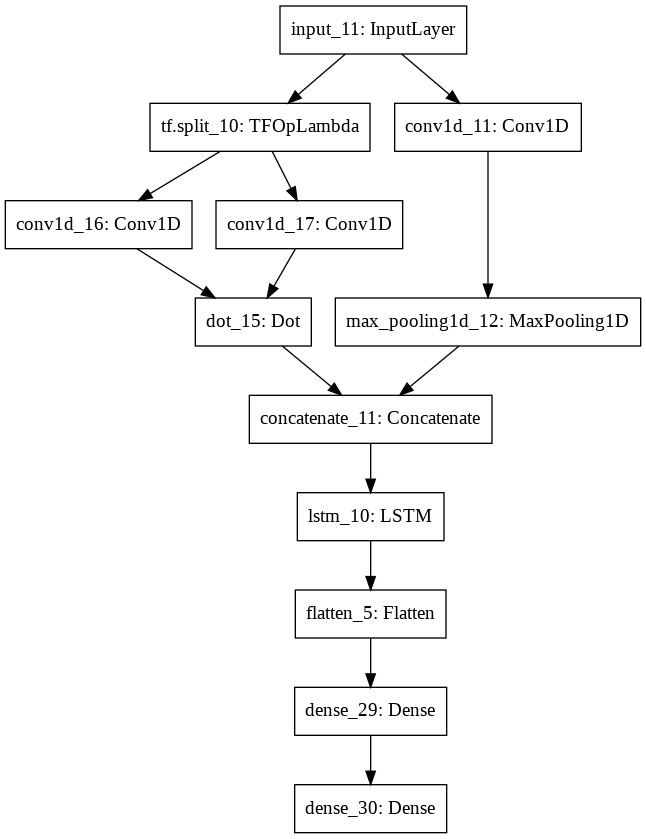

In [7]:
from keras.utils import plot_model
plot_model(model_8_1, to_file="{}/shot_split/model_split_8.1.png".format(sourcefolder))

In [37]:
model_8_1.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 8, 3584)]    0                                            
__________________________________________________________________________________________________
tf.split_10 (TFOpLambda)        [(None, 4, 3584), (N 0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 7, 100)       716900      input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 3, 100)       716900      tf.split_10[0][0]                
___________________________________________________________________________________________